# Programming Assignment: Выбор семейства распределений в наивном байесе

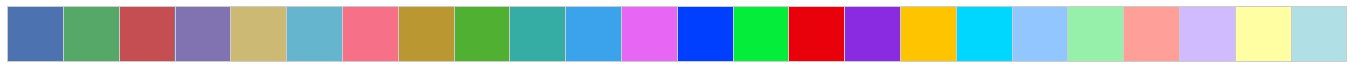

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

In [2]:
from sklearn import datasets, metrics, model_selection as mdsel, naive_bayes

В этом задании вы сможете немного расслабиться после реализации случайного леса и градиентного бустинга по мотивам материалов прошлой недели. Все, что нужно будет делать — запускать методы из sklearn. Вам предлагается выяснить, какое распределение лучше использовать в наивном байесовском классификаторе в зависимости от вида признаков.

Загрузите датасеты digits и breast_cancer из sklearn.datasets. Выведите несколько строчек из обучающих выборок и посмотрите на признаки. 

In [7]:
digits_data = datasets.load_digits()
breast_data = datasets.load_breast_cancer()

In [25]:
digits_data['images'].shape, digits_data['data'].shape, digits_data['target'].shape, digits_data['target_names']

((1797, 8, 8), (1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [28]:
print(breast_data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [31]:
print(breast_data.keys())
print('_________')
print(breast_data['data'].shape, breast_data['feature_names'])
print('_________')
print(breast_data['target'].shape, breast_data['target_names'])

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
_________
(569, 30) ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
_________
(569,) ['malignant' 'benign']


In [6]:
digits_X, digits_y = datasets.load_digits(return_X_y=True)
breast_X, breast_y = datasets.load_breast_cancer(return_X_y=True)

In [33]:
digits_X[:3], digits_y[:3]

(array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
         15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
         12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
          0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
         10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,
          9.,  0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7.,
         15., 16., 16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,
          0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16.,
         16.,  6.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.,  0.,  0.,  3., 16., 15.,
         14.,  0.,  0.,  0.,  0.,  8., 13.,  8., 16.,  0.,  0.,  0.,  0.,
          1.,  6., 15., 11.,  0.,  0.,  0.,  1.,  8., 13., 15.,  1.,  0.,
          0.,  0.,  9., 16., 16.,  5.,  0.,  0

In [37]:
ndprint(breast_X[:3])
breast_y[:3]

[[  17.99    10.38   122.8   1001.       0.118    0.278    0.3      0.147
     0.242    0.079    1.095    0.905    8.589  153.4      0.006    0.049
     0.054    0.016    0.03     0.006   25.38    17.33   184.6   2019.
     0.162    0.666    0.712    0.265    0.46     0.119]
 [  20.57    17.77   132.9   1326.       0.085    0.079    0.087    0.07
     0.181    0.057    0.543    0.734    3.398   74.08     0.005    0.013
     0.019    0.013    0.014    0.004   24.99    23.41   158.8   1956.
     0.124    0.187    0.242    0.186    0.275    0.089]
 [  19.69    21.25   130.    1203.       0.11     0.16     0.197    0.128
     0.207    0.06     0.746    0.787    4.585   94.03     0.006    0.04
     0.038    0.021    0.022    0.005   23.57    25.53   152.5   1709.
     0.144    0.424    0.45     0.243    0.361    0.088]]


array([0, 0, 0])

С помощью sklearn.cross_validation.cross_val_score c настройками по умолчанию и вызова метода mean() у возвращаемого этой функцией numpy.ndarray, сравните качество работы наивных байесовских классификаторов на этих двух датасетах. Для сравнения предлагается использовать BernoulliNB, MultinomialNB и GaussianNB. Насколько полученные результаты согласуются с рекомендациями из лекций?

In [42]:
type(naive_bayes.BernoulliNB()).__name__ 

'BernoulliNB'

In [61]:
datas = [(digits_X, digits_y), (breast_X, breast_y)]
estimators = [
    naive_bayes.BernoulliNB(),
    naive_bayes.MultinomialNB(),
    naive_bayes.GaussianNB()
]

digits_results = [
    (type(estimator).__name__, np.mean(cross_val_score))
    for estimator in estimators
    for cross_val_score in [mdsel.cross_val_score(estimator, digits_X, digits_y, cv=3)]
]
digits_results

[('BernoulliNB', 0.8258236507780582),
 ('MultinomialNB', 0.8708771489735053),
 ('GaussianNB', 0.8186003803550138)]

In [62]:
breasts_results = [
    (type(estimator).__name__, np.mean(cross_val_score))
    for estimator in estimators
    for cross_val_score in [mdsel.cross_val_score(estimator, breast_X, breast_y, cv=3)]
]
breasts_results

[('BernoulliNB', 0.6274204028589994),
 ('MultinomialNB', 0.8945790401930752),
 ('GaussianNB', 0.9367492806089297)]

Два датасета, конечно, еще не повод делать далеко идущие выводы, но при желании вы можете продолжить исследование на других выборках (например, из UCI репозитория).

Для сдачи задания, ответьте на приведенные ниже вопросы.

In [50]:
def write_answer(result, ans_ind):
    path = f'out/22_naive_bayes{ans_ind}.txt'
    result_str = result if isinstance(result, str) else str(result)
    with open(path, "w") as fout:
        fout.write(result_str)

#### Вопрос 1

Каким получилось максимальное качество классификации на датасете breast_cancer?

In [56]:
result = np.max([res for name, res in breasts_results])
write_answer(result, 1)
result

0.9367492806089297

#### Вопрос 2

Каким получилось максимальное качество классификации на датасете digits?

In [57]:
result = np.max([res for name, res in digits_results])
write_answer(result, 2)
result

0.8708771489735053

#### Вопрос 3

Выберите верные утверждения и запишите их номера через пробел (в порядке возрастания номера):

1) На вещественных признаках лучше всего сработал наивный байесовский классификатор с распределением Бернулли

2) На вещественных признаках лучше всего сработал наивный байесовский классификатор с мультиномиальным распределением

3) Мультиномиальное распределение лучше показало себя на выборке с целыми неотрицательными значениями признаков

4) На вещественных признаках лучше всего сработало нормальное распределение

In [63]:
write_answer('3 4', 3)